In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, make_alt_vocab

In [8]:
from collections import namedtuple, OrderedDict

# Confidence intervals across vocab

# Effect of intercept modification

I expect it to give more distinct trends

In [2]:
dimensions = 64
n_neurons = 1000
seed = 8
p_fan = 0.85

In [3]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(16, 16, dimensibons, seed, norm=True)

In [5]:
mean_fan1 = np.mean(fan1_vecs, axis=0)
mean_fan2 = np.mean(fan2_vecs, axis=0)

In [6]:
encoders = np.zeros((n_neurons, dimensions))

fan1_end = int(n_neurons * p_fan)
print(fan1_end)

for n_i in range(fan1_end):
    encoders[n_i] = mean_fan1 + np.random.normal(size=dimensions)*0.1

for n_i in range(fan1_end, n_neurons):
    encoders[n_i] = mean_fan2 + np.random.normal(size=dimensions)*0.1

850


In [ ]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_vecs)),
             "fan2": Stim(2, True, np.array(fan2_vecs)),
             "foil1": Stim(1, False, np.array(foil1_vecs)),
             "foil2": Stim(2, False, np.array(foil2_vecs))}

Act = namedtuple("act", ['fan_num', 'targ', 'act'])

## Base Case

In [58]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                           


In [59]:
acts = dict()

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
    acts[key] = Act(obj.fan_num, obj.targ, act)

In [60]:
df_list = []

for key, obj in acts.items():
    act = obj.act.flatten()
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": list(act), "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

(60, 110)

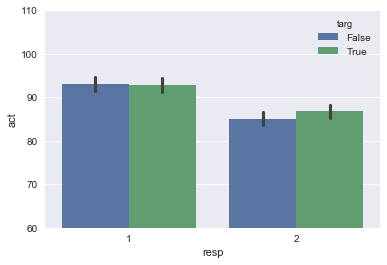

In [61]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)
ax.set_ylim((60, 110))

Number of neurons basically firing for both vectors
354


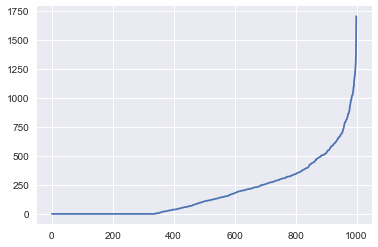

In [63]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(acts["fan1"].act, axis=0) - np.sum(acts["fan2"].act, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

## With modified intercepts

In [64]:
simi = 0.3
int_a = nengo.dists.Uniform(-1.0, -simi).sample(n_neurons // 2)
int_b = nengo.dists.Uniform(simi, 1.0).sample(n_neurons - len(int_a))
intercepts = np.concatenate((int_a, int_b))
print(intercepts.shape)

(1000,)


In [65]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders, intercepts=intercepts)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                           


In [66]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])
Act = namedtuple("act", ['fan_num', 'targ', 'act'])

stim_vecs = {"fan1": Stim(1, True, np.array(fan1_vecs)),
             "fan2": Stim(2, True, np.array(fan2_vecs)),
             "foil1": Stim(1, False, np.array(foil1_vecs)),
             "foil2": Stim(2, False, np.array(foil2_vecs))}
acts = dict()

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
    acts[key] = Act(obj.fan_num, obj.targ, act)

In [67]:
df_list = []

for key, obj in acts.items():
    act = obj.act.flatten()
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": list(act), "resp": resp, "targ": targ}))

int_act_df = pd.concat(df_list)

(60, 110)

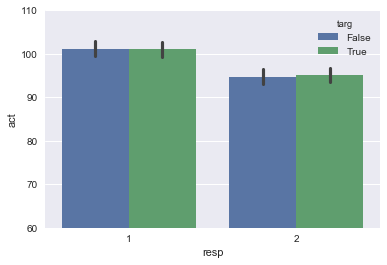

In [68]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=int_act_df)
ax.set_ylim((60, 110))

Number of neurons basically firing for both vectors
354


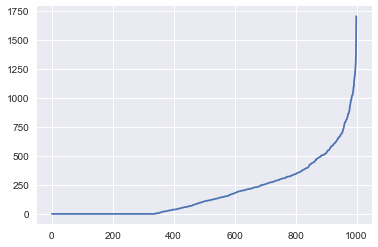

In [63]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(acts["fan1"].act, axis=0) - np.sum(acts["fan2"].act, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

Does appear to make the trend stronger while also increasing the firing rate, but surprisingly doesn't decrease the amount of neurons firing for both FAN1 and FAN2.

# Demonstration of memory operating over time

# Effect of noisier encoders

# Effect of noisier inputs

# Effect of memory as associative

## Can you learn an associative memory off the Ensemble using PES?

## Does this intermediary ensemble change the performance of an engineered associative memory?